In [1]:
import os, sys

import pandas as pd
import numpy as np

from pathlib import Path
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: MacOSX


This notebook contains 
- Preparation
- EDA: A single year of data
- Looking at the entire data
- Clustering

Especially the last two chapters are interesting and were used to generate images for the presentation.

### Preparation

In [2]:
name = "10044" # Kiel (SPO is 10028)

p = Path("..") / "data" / "raw" / "data_windfinder"
weather_files = list(os.listdir(p))
weather_files = [file for file in weather_files if ("weatherdata" in file) and (name in file)]
weather_files = sorted(weather_files)
views_files = list(os.listdir(p))
views_files = [file for file in views_files if ("pageviews" in file) and (name in file)]
views_files = sorted(views_files)

### EDA: A single year of data (weather and page views)
First, we focus on a single year (2016), and understand what kind of data we exactly have.
Then, we investigate what the top 10% of page views look like in terms of wind direction.

In [3]:
df = pd.read_csv(p / weather_files[0], delimiter=';', parse_dates=[0])
df.drop(['wind gust [kts]'], axis=1, inplace=True)
df['date'] = df.apply(lambda row: datetime(year=row['date/time (UTC)'].year, month=row['date/time (UTC)'].month, day=row['date/time (UTC)'].day), axis=1)

def add_weekdays_onehot(df: pd.DataFrame, date_column_name: str):
    rename_cols_dict = {0: 'monday', 1: 'tuesday', 2: 'wednesday',
                        3: 'thursday', 4: 'friday', 5: 'saturday',
                        6: 'sunday'}
    # to make sure that all dataframes have all days, add 0-6 and delete it afterwards
    weekdays = pd.get_dummies(pd.concat([df[date_column_name].dt.weekday, pd.Series(np.arange(7))], axis=0)).iloc[:-7].rename(columns=rename_cols_dict)
    return pd.concat([df, weekdays], axis=1)

In [4]:
df['date/time (UTC)']

0       2016-01-01 00:08:00
1       2016-01-01 01:36:00
2       2016-01-01 01:52:00
3       2016-01-01 02:08:00
4       2016-01-01 02:16:00
                ...        
45771   2016-12-31 23:12:00
45772   2016-12-31 23:20:00
45773   2016-12-31 23:28:00
45774   2016-12-31 23:36:00
45775   2016-12-31 23:52:00
Name: date/time (UTC), Length: 45776, dtype: datetime64[ns]

In [5]:
# df = add_weekdays_onehot(df, 'date')
df

,date/time (UTC),wind speed [kts],wind direction [degrees],air temperature [°C],date
0,2016-01-01 00:08:00,16.0,208,6.0,2016-01-01
1,2016-01-01 01:36:00,12.0,194,6.0,2016-01-01
2,2016-01-01 01:52:00,14.0,193,6.0,2016-01-01
3,2016-01-01 02:08:00,12.0,192,6.0,2016-01-01
4,2016-01-01 02:16:00,12.0,185,6.0,2016-01-01
...,...,...,...,...,...
45771,2016-12-31 23:12:00,21.0,231,6.0,2016-12-31
45772,2016-12-31 23:20:00,21.0,231,6.0,2016-12-31
45773,2016-12-31 23:28:00,21.0,232,6.0,2016-12-31
45774,2016-12-31 23:36:00,19.0,226,6.0,2016-12-31


In [6]:
mins = df['date/time (UTC)'].dt.minute
mask = (mins == 0)
df = df.loc[mask]

In [7]:
# mask = (df['date/time (UTC)'].diff() > timedelta(hours=1))
# some hours are missing

In [8]:
df_views = pd.read_csv(p / views_files[0], delimiter=';', parse_dates=[0], header=None, names=['date', 'counts'])
# todo: remove seasonality, e.g., more view on weekends

In [9]:
df_views

,date,counts
0,2016-01-01,1330
1,2016-01-02,2232
2,2016-01-03,1977
3,2016-01-04,1784
4,2016-01-05,1636
...,...,...
361,2016-12-27,2894
362,2016-12-28,1248
363,2016-12-29,1254
364,2016-12-30,1099


In [10]:
percentage = 0.1
sorted_dates = df_views.sort_values('counts', ascending=False)
dates = sorted_dates.iloc[:int(len(sorted_dates) * percentage), 0]

In [11]:
# sorted_dates

In [12]:
# dates

In [13]:
mask = df.apply(lambda row: row.date in dates.values, axis=1)

In [14]:
top_10_days = df[mask]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9f2cca3d0>,
      dtype=object)

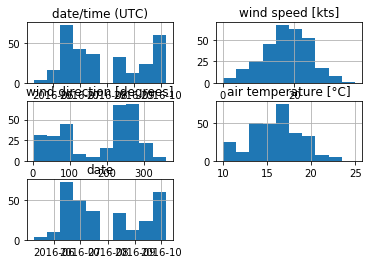

In [15]:
top_10_days.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9f2f41e50>,
      dtype=object)

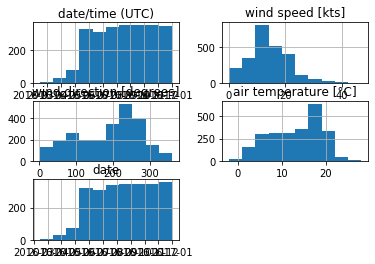

In [16]:
df.hist()

We can already see that there is a difference in distribution in wind direction (histograms above).
However, when looking at the top view counts, we also see that they mostly occur in the summer, probably as more people want to do outdoor sports in the summer.

We are more interested in when the page views are unexpectedly high (in summer, one would expect them to be high), so we want to deseasonalize the data.

## Looking at the entire data
Here, we look at the entire dataset for Kiel. As mentioned just above, we deseasonalize (and detrend) the page views, and then look at the residuals to filter out on which days the page views were unexpectedly high (top 5% here). For these days, we look at the wind direction and wind speed.

As we can see on the scatter plot, there definitely is a pattern in the wind direction and wind speed on those high page view days (red, compared to the scatter plot of all days in blue).

We can clearly see two clusters. We then compute the cluster centers, and the distance from the closest cluster center can be used as a measure for how good surfing conditions are.

In [17]:
years = [2016, 2017, 2018, 2019]
views_files

df_all_views = pd.read_csv(p / views_files[0], delimiter=';', parse_dates=[0], header=None, names=['date', 'counts_2016'])
df_views = pd.read_csv(p / views_files[0], delimiter=';', parse_dates=[0], header=None, names=['date', 'counts'])


for y, fn in list(zip(years, views_files))[1:3]:
    df_views_year = pd.read_csv(p / fn, delimiter=';', parse_dates=[0], header=None, names=['date', f'counts'])
    df_all_views[f"counts_{str(y)}"] = df_views_year[f"counts"]
    df_views = df_views.append(df_views_year)
    
df_all_views = add_weekdays_onehot(df_all_views, 'date')

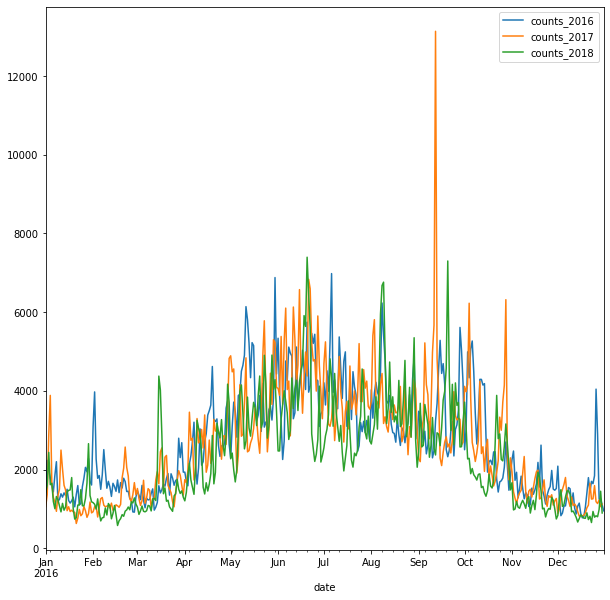

In [18]:
# what do page counts actually look like?
ys = [f"counts_{str(year)}" for year in years[0:3]]
plt = df_all_views.plot(x='date', y=ys, figsize=[10, 10]).get_figure()

In [19]:
# plt.savefig('Kiel_pagecounts.png')
# df_views

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


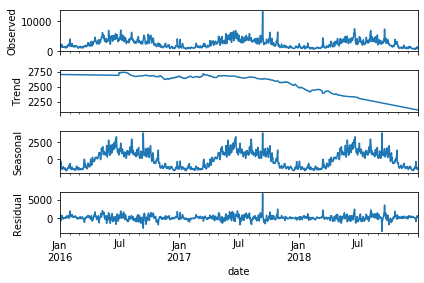

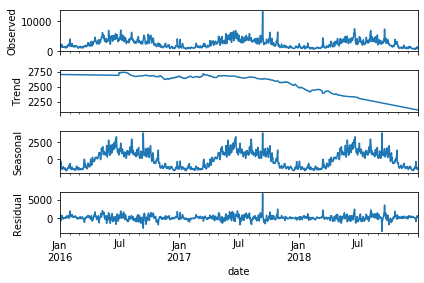

In [20]:
# compute seasonality and trend
from statsmodels.tsa.seasonal import seasonal_decompose
df_views.set_index('date',inplace=True)
df_views.index=pd.to_datetime(df_views.index)
result=seasonal_decompose(df_views['counts'], model='additive', freq=365, extrapolate_trend='freq')
result.plot()

In [21]:
# result.resid # this is the residual

In [22]:
# get top x percent (here 5 percent) of highest residuals, i.e., days with unexpectedly high page views

percentage = 0.05
sorted_dates = result.resid.sort_values(ascending=False)
dates = sorted_dates.iloc[:int(len(sorted_dates) * percentage)].index.values

In [23]:
# dates # these dates are the top 5% with highest page counts

In [24]:
# load data for all years
dfs = pd.read_csv(p / weather_files[0], delimiter=';', parse_dates=[0])
for fn in weather_files[1:]:
    df = pd.read_csv(p / fn, delimiter=';', parse_dates=[0])
    dfs = dfs.append(df)
    
dfs['date'] = dfs.apply(lambda row: datetime(year=row['date/time (UTC)'].year, month=row['date/time (UTC)'].month, day=row['date/time (UTC)'].day), axis=1)
dfs.drop(['wind gust [kts]'], axis=1, inplace=True)
dfs.dropna(inplace=True)

In [25]:
# dfs

In [26]:
# get data for top days (set how many percent above)
mask = dfs.apply(lambda row: row.date in dates, axis=1)
top_x_percent = dfs[mask]

In [27]:
top_x_percent # this is the dataset for top x percent

,date/time (UTC),wind speed [kts],wind direction [degrees],air temperature [°C],date
3421,2016-02-02 09:20:00,35.0,236,7.0,2016-02-02
3422,2016-02-02 09:28:00,39.0,241,7.0,2016-02-02
3423,2016-02-02 09:36:00,35.0,237,7.0,2016-02-02
3424,2016-02-02 09:52:00,35.0,237,7.0,2016-02-02
3425,2016-02-02 10:08:00,39.0,237,8.0,2016-02-02
...,...,...,...,...,...
41879,2018-10-23 23:12:00,33.0,305,12.0,2018-10-23
41880,2018-10-23 23:20:00,37.0,310,12.0,2018-10-23
41881,2018-10-23 23:28:00,37.0,310,12.0,2018-10-23
41882,2018-10-23 23:36:00,37.0,309,12.0,2018-10-23


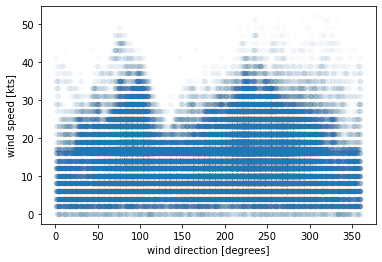

In [28]:
# plot wind direction and speed distribution for all observations
ax2 = dfs.plot.scatter(x='wind direction [degrees]', y='wind speed [kts]', alpha=.01)

In [29]:
# plt2 = ax2.get_figure()
# plt2.savefig('Kiel_all_all_day.png')

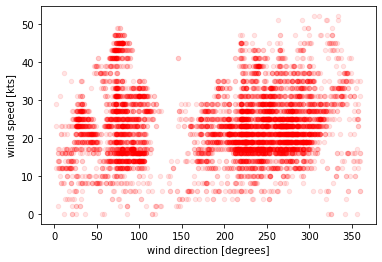

In [30]:
# plot wind direction and speed distribution for top x days
ax = top_x_percent.plot.scatter(x='wind direction [degrees]', y='wind speed [kts]', alpha=.1, color='r')

In [31]:
# fig = top_x_percent.plot.scatter(x='wind direction [degrees]', y='wind speed [kts]', alpha=.1, color='r').get_figure()
# fig.savefig(f"Kiel_top5percent.png")

## Clustering
Now, we want to look at the clusters using kmeans. As kmeans uses distances, we normalize wind speed and direction.

As described above, the proximity to the closest cluster can be seen as a proxy for surfing conditions.

In [32]:
new_df = top_x_percent.copy()

In [33]:
## PARAMETER n_clusters
n_clusters = 2

from sklearn.cluster import KMeans

# normalization
new_df['speed'] = new_df['wind speed [kts]'] / 50
new_df['direction'] = new_df['wind direction [degrees]'] / 360

speed_direction = new_df[['speed', 'direction']].values

km = KMeans(n_clusters=n_clusters, random_state=42).fit(speed_direction)

In [34]:
# km.cluster_centers_

In [35]:
def transform_back(xy):
    x, y = xy
    return [x * 50, y * 360]
centers = np.array([transform_back(xy) for xy in km.cluster_centers_])

In [36]:
centers

array([[ 23.12448304,  73.2299421 ],
       [ 23.13825758, 252.57954545]])

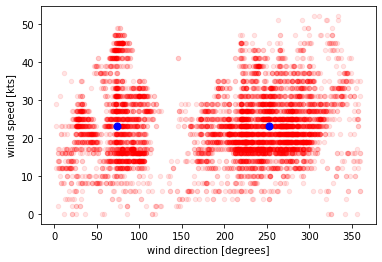

In [37]:
speed = centers[:, 0]
direction = centers[:, 1]
ax.plot(direction, speed, 'b.', markersize=14)
ax.get_figure()

In [38]:
plt = ax.get_figure()
# plt.savefig(f"Kiel_cluster_{n_clusters}.png")